In [3]:
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import csv
import pandas as pd
from tqdm import tnrange, tqdm
from datetime import datetime
import xlwt
from xlwt import Workbook

class Ising():
    ''' Simulating the Ising model '''    
    ## monte carlo moves
    def mcmove(self, config, N, beta, h):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):            
                    a = np.random.randint(1, N-1)
                    b = np.random.randint(0, N)
                    if a == len(config) :
                        s =  config[a, b]
                        nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N] - h 
                        cost = 2*s*nb
                    elif a == 0:
                        s =  config[a, b]
                        nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N] + h 
                        cost = 2*s*nb
                    else :
                        s =  config[a, b]
                        nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                        cost = 2*s*nb
                    if cost < 0:	
                        s *= -1
                    elif rand() < np.exp(-1*cost*beta):
                        s *= -1
                    else:
                        s *= 1
                    config[a, b] = s
        return config  
    
    def configPlot(self, f, config, i, N, n_):
        ''' This modules plts the configuration once passed to it along with time etc '''
        X, Y = np.meshgrid(range(N), range(N))
        sp =  f.add_subplot(3, 3, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)      
        plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu);
        plt.title('Time=%d'%i); plt.axis('tight')    
    plt.show()
    
    def cov(self, temp, Matrix):
        for i in range(len(temp)):
            for j in range(len(temp)):
                Matrix[i][j] = temp[i]*temp[j]
        return Matrix
    
    def calcEnergy(self, config, h):
        '''Energy of a given configuration'''
        N = len(config)
        energy = 0
        for i in range(len(config)):
            for j in range(len(config)):
                if i == len(config):
                    S = config[i,j]
                    nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N] + h
                    energy += -nb*S
                elif i == 0:
                    S = config[i,j]
                    nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N] - h
                    energy += -nb*S
                else :
                    S = config[i,j]
                    nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N] 
                    energy += -nb*S
        return energy/4.



    def calcMag(self, config):
        '''Magnetization of a given configuration'''
        mag = np.sum(config)
        return mag
    
    def simulate(self):   
        
        ''' This module simulates the Ising model'''
        
        N = 64        # Initialse the lattice
        h = 0        #external field
        N_intermediate_points = 1       #  number of temperature points
        T_min = 1.40                         #  lower range for temperature
        T_max = 2.10                         #  upper range for temperature
        T = np.linspace(T_min, T_max, N_intermediate_points);      #divisions T min and T max into different temperature steps 
        bin_histogram = np.linspace(-1*(N**2), (N**2), 250)
        bin_histogram1 = np.linspace(-1*(N**2), 0, 600)
        
        average_height_different_temperature = []
        
        
        config = 2*np.random.randint(2, size=(N,N))-1
        for i in range(N):
            config[0,i] = -1
            config[N-1,i] = 1
        f = plt.figure(figsize=(15, 15), dpi=80);    
        self.configPlot(f, config, 0, N, 1);
        
        msrmnt = 100001
        for l in range(len(T)):
            
            Lattice_number = []
            average_height_per_column = []
            average_height_film = 0
            square_average_height_per_column = []
            square_average_height_film = 0
            ens_avg_zizj = []
            mag = 0
            mag_square = 0
            energy = []
            magnetization = []
            simulation_step = []
            eng = 0
            eng_square = 0
            
            wb = Workbook()
            sheet1 = wb.add_sheet('Heights')
            sheet2 = wb.add_sheet('Spins')
            sheet3 = wb.add_sheet('Hamiltonian')
            sheet4 = wb.add_sheet('Magnetization')
        
            #Matrix_1 = [[0]*N]*N
            #Matrix_2 = [[0]*N]*N
            #Covariance = [[0]*N]*N
        
            for i in range(N):
                average_height_per_column.append(0)
                square_average_height_per_column.append(0)
                Lattice_number.append(i+1)
                ens_avg_zizj.append(0)
            
            for i in range(msrmnt):
                self.mcmove(config, N, 1.0/1.40, h)
                #temp = []
                #Matrix = [[0]*N]*N
                if i%100 == 0:
                    for j in range(N):
                        count = 0
                        for k in range(N-2):
                            if config[N-k-1,j] == -1 and config[N-k-2,j] == -1 and config[N-k-3,j] == -1 :
                                count = N - k
                                break
                        
                        sheet1.write(int((i/100)+1), j+1, str(count))
                        sheet2.write(int((i/100)+1), j+1, str(config[N-2,j]))
                        sheet3.write(int((i/100)+1), j+1, str(self.calcEnergy(config, h)))
                        sheet4.write(int((i/100)+1), j+1, str(self.calcMag(config)))
                        
                        #average_height_per_column[j] = average_height_per_column[j] + (count)
                        #square_average_height_per_column[j] = square_average_height_per_column[j] + (count**2)
                        #if j == 0:
                         #   ens_avg_zizj[j] = ens_avg_zizj[j] + (count**2)
                        #else: 
                         #   ens_avg_zizj[j] = ens_avg_zizj[j] + (count*ens_avg_zizj[0])
                        #temp.append(count)
                        
                mag += self.calcMag(config)/(N**2)
                mag_square += ((self.calcMag(config)**2)/(N**2))
                eng += self.calcEnergy(config, h)/(N**2)
                eng_square += ((self.calcEnergy(config, h)**2)/(N**2))
                energy.append(self.calcEnergy(config, h))
                magnetization.append(self.calcMag(config))
                #Matrix_1 += self.cov(temp, Matrix)
                simulation_step.append(i)
            
                if i == 1:       self.configPlot(f, config, i, N, 2);
                if i == 4:       self.configPlot(f, config, i, N, 3);
                if i == 32:      self.configPlot(f, config, i, N, 4);
                if i == 1000:     self.configPlot(f, config, i, N, 5);
                if i == 10000:     self.configPlot(f, config, i, N, 6);
                if i == 20000:     self.configPlot(f, config, i, N, 7);
                if i == 50000:     self.configPlot(f, config, i, N, 8);
                if i == 100000:     self.configPlot(f, config, i, N, 9);
                
            #for j in range(N):
             #   average_height_per_column[j] = round(((average_height_per_column[j])/(0.8*(msrmnt-1))), 3)
              #  square_average_height_per_column[j] = round(((square_average_height_per_column[j])/(0.8*(msrmnt-1))), 3)
               # ens_avg_zizj[j] = round(((ens_avg_zizj[j])/(0.8*(msrmnt-1))), 3)
            
            mag = mag/(msrmnt-1)
            mag_square = mag_square/(msrmnt-1)
            sigma_mag = mag_square - (mag**2)
            eng = eng/(msrmnt-1)
            eng_square = eng_square/(msrmnt-1)
            sigma_eng = eng_square - (eng**2)
            
            fig, ax = plt.subplots(figsize =(25, 18)) 
            ax.hist(energy, bins = bin_histogram1)
            plt.show()
            
            fig, ax = plt.subplots(figsize =(25, 18)) 
            ax.hist(magnetization, bins = bin_histogram)
            plt.show()
                        
            wb.save('Height & Spin Data')
        
            print(mag)
            print(mag_square)
            print(eng)
            print(eng_square)
            print(sigma_mag)
            print(sigma_eng)
            
            #for i in range(N):
            #   for j in range(N):
            #        Matrix_1[i][j] /= (0.8*(msrmnt-1))
        
            #for i in range(N):
             #   for j in range(N):
              #      Covariance[i][j] = Matrix_1[i][j] - Matrix_2[i][j]
                
            #print(Matrix_1)
            #print(Matrix_2)
            #print(Covariance)
        
            #sum_1 = 0.0
            #sum_2 = 0.0
        
            #for j in range(N):
            #    sum_1 += average_height_per_column[j]
            #    sum_2 += square_average_height_per_column[j]
            #    
            #average_height_film = (sum_1)/N
            #square_average_height_film = (sum_2)/N
            #average_height_different_temperature.append(average_height_film)
            

            #print("An array of the average height per column is given below:-")
            #print("----")
            #print(average_height_per_column)
            #print("----")
            #print("An array of the squared average height per column is given below:-")
            #print("----")
            #print(square_average_height_per_column)
            #print("----")
            #print("The average height of the film = %0.2f" %average_height_film)
            #print("----")
            #print("The squared average height of the film = %0.2f" %square_average_height_film)
        
            #f = plt.figure(figsize=(6, 4)); # plot the calculated values    
    
            #sp =  f.add_subplot(1, 1, 1 );
            #plt.scatter(Lattice_number, average_height_per_column, s=50, marker='o', color='IndianRed')
            #plt.xlabel("Lattice number", fontsize=20);
            #plt.ylabel("average height per column", fontsize=20);         #plt.axis('tight');
        
        #f = plt.figure(figsize=(15, 10)); # plot the calculated values    
    
        #sp =  f.add_subplot(1, 1, 1 );
        #plt.scatter(T, average_height_different_temperature, s=50, marker='o', color='RoyalBlue')
        #plt.xlabel("Temperature", fontsize=20);
        #plt.ylabel("Average Height of Film", fontsize=20);         #plt.axis('tight');


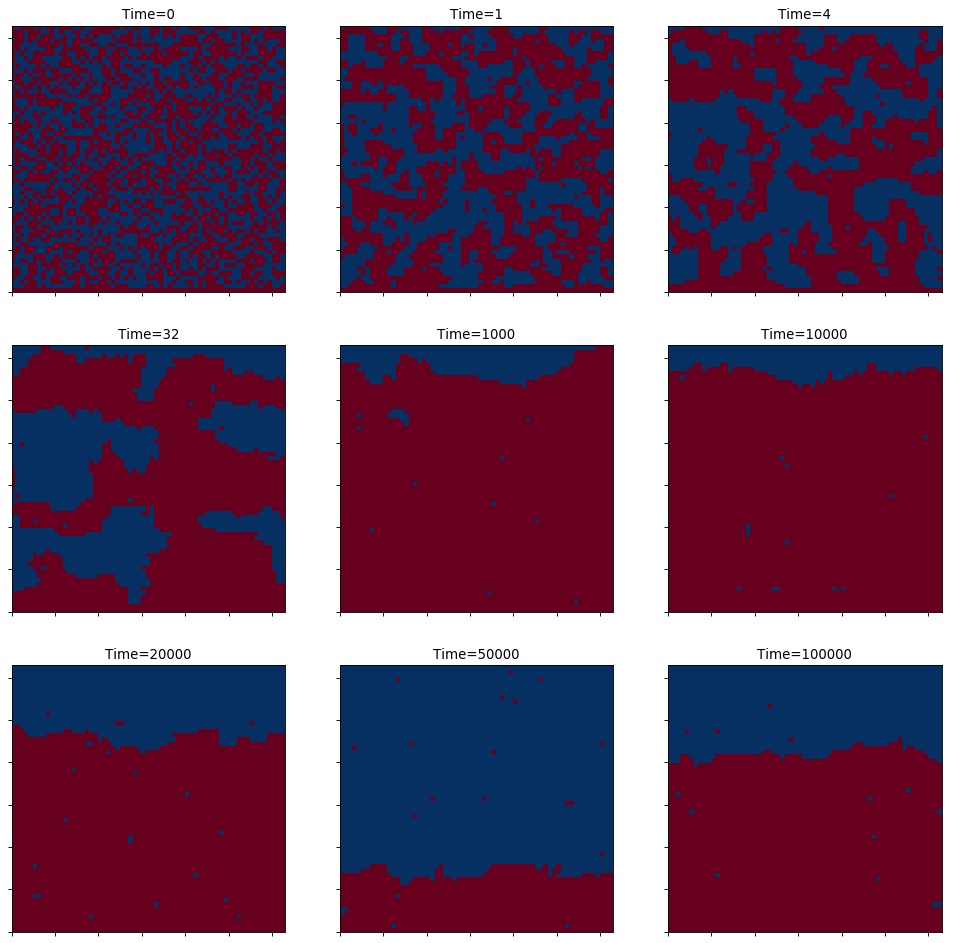

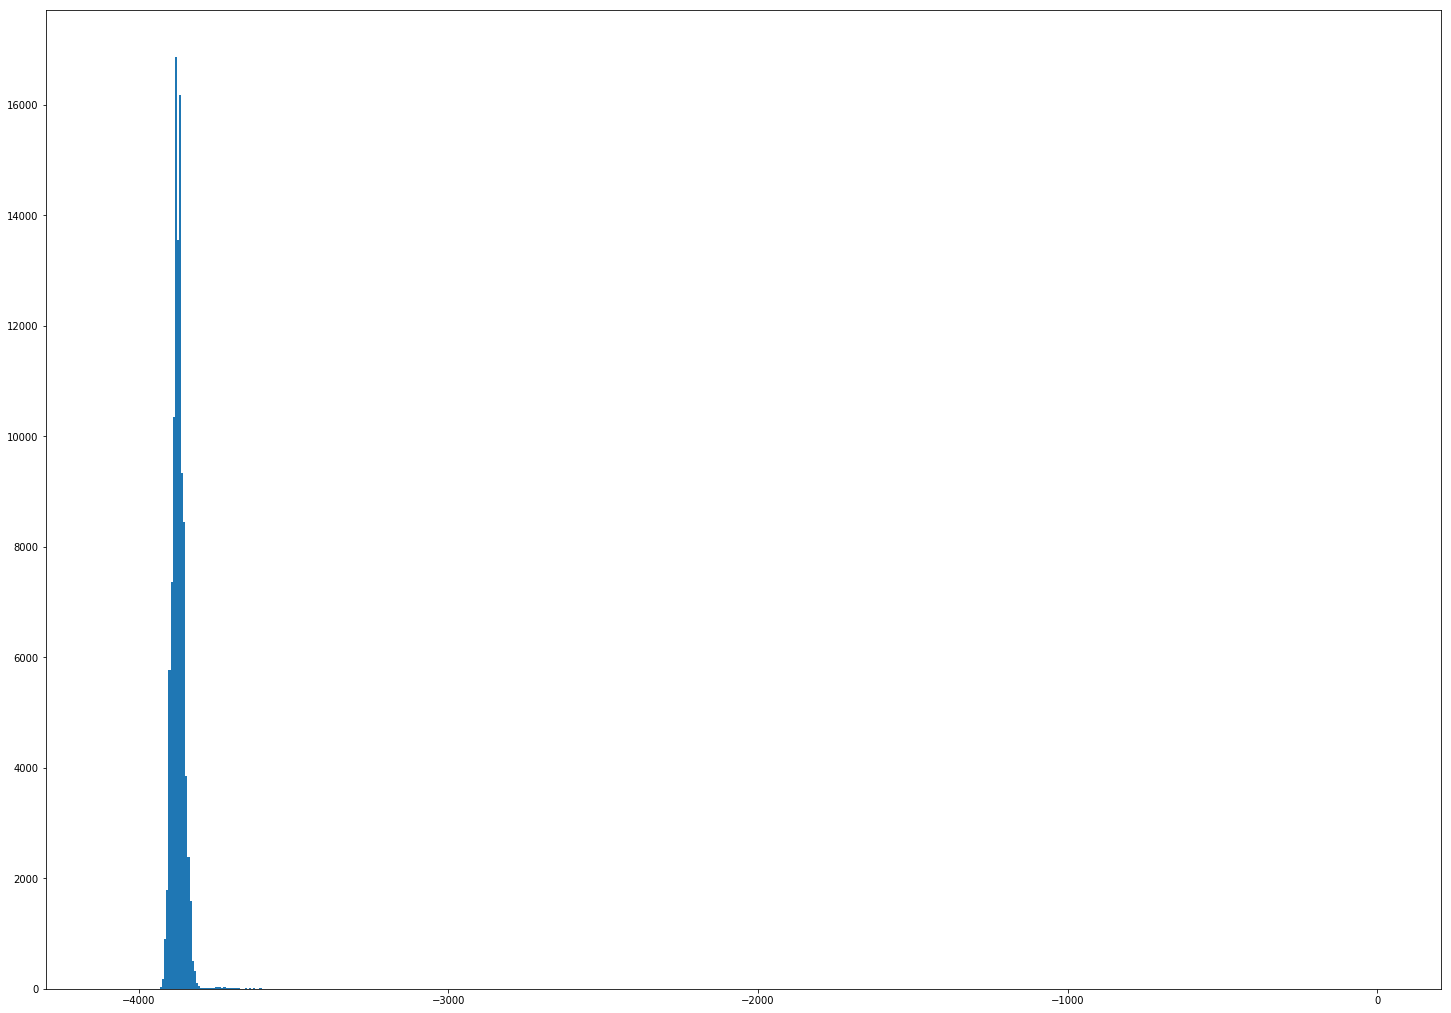

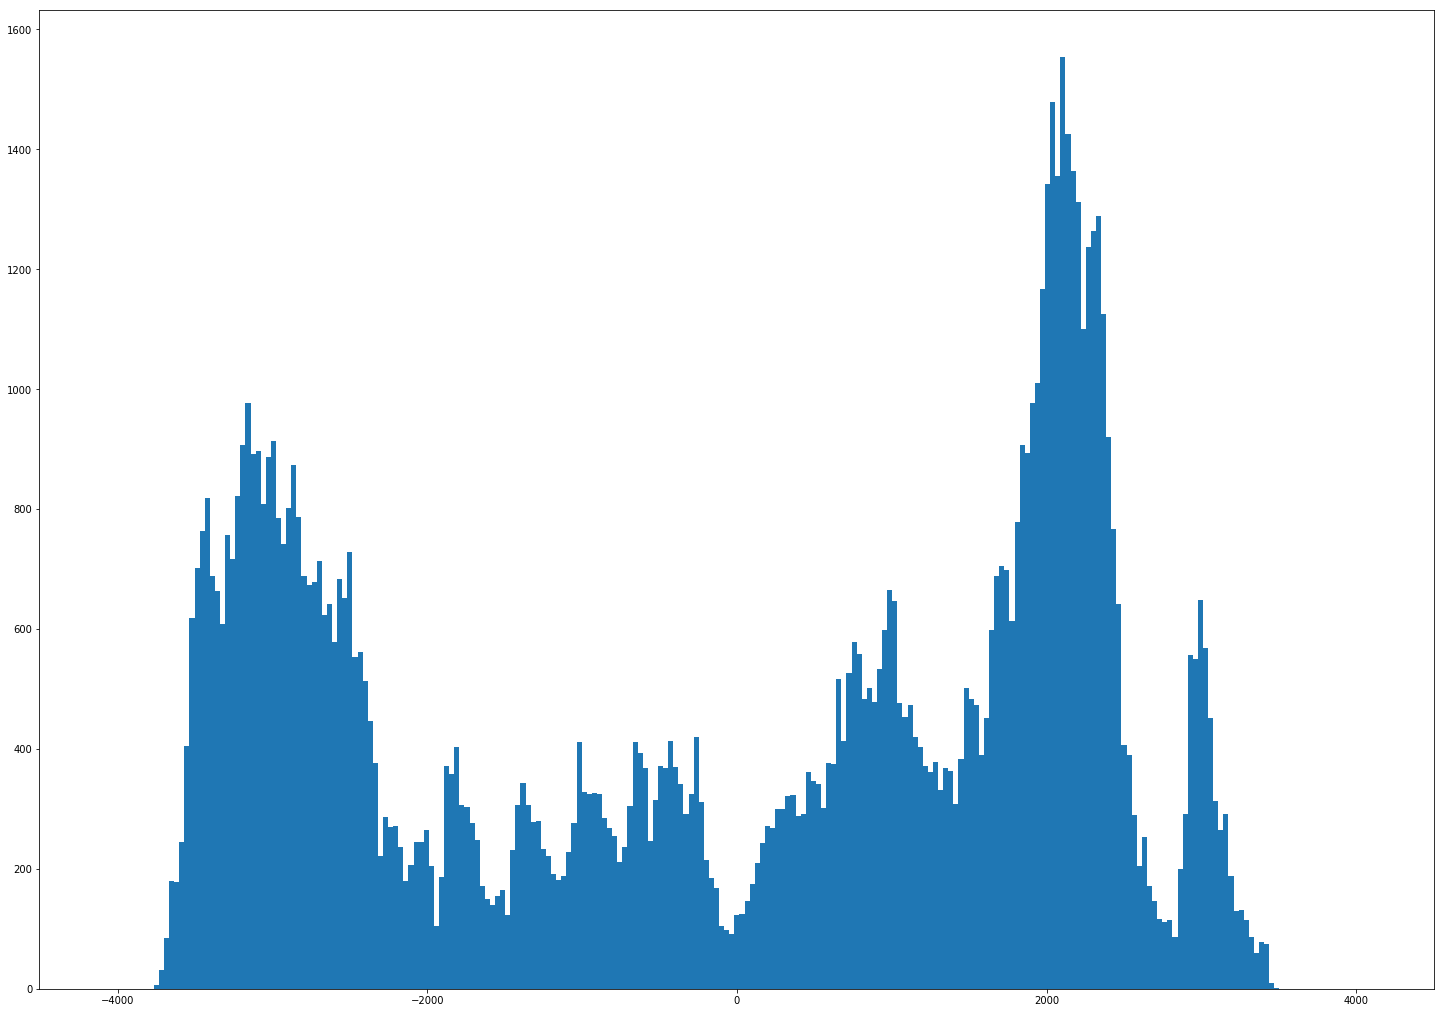

-0.0202830029296875
1179.772602216797
-0.9454392431640625
3661.367021630859
1179.772190816589
3660.4731662683444


In [4]:
rm = Ising()
rm.simulate()